
# Dynamic SIMM for MVA and CVA

OTC derivatives business is typically collateralized with both Variation Margin (VM) and Initial Margin (IM) nowadays. This means over-collateralization in many scenarios, though extreme scenarios and market stress can lead to significant exposure and losses. More so, wrong-way risk can even cause significant expected losses, despite of VM and IM. 

For a given netting set, IM is both called from the counterparty and posted to the counterparty. These IM amounts might differ, and they are not netted. 

IM **called from** the counterparty suppresses credit exposure and CVA (in normal markets, without wrong-way risk); for credit exposure and CVA modelling we need to evaluate IM path-wise to offset the exposure after VM correctly on each path, before we compute the residual exposure after VM and IM.
  
IM **posted to** the counterparty causes additional funding cost that are priced as Margin Value Adjustment (MVA); its key ingredient is the Expected (Discounted) Future IM through the life of the portfolio.
 
To compute IM, the Dynamic SIMM method in ORE embeds full ISDA SIMM calculation into ORE's American Monte Carlo simulation framework with fast pathwise sensitivity calculation using AAD. 

The examples below consider a netting set containing a single Bermudan Swaption (in EUR, cash settled, maturity 10Y, annual exercise from 5Y onwards). The market data used here is close to realistic but somewhat stressed (compared to the reference market in February 2025) with flat normal Swaption volatility at 150bp.

Prerequisites:
- Python 3
- ORE Python module: run "**pip install open-source-risk-engine**" to get the latest version
- Matplotlib: pip install matplotlib

### Import modules

In [1]:
from ORE import *

import sys, time, math
sys.path.append('..')

import utilities

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Example 1: Standard AMC, Variation Margin

This example assumes Variation Margin only, no Initial Margin yet. We apply the usual AMC framework with a close-out grid for VM modelling and 10k samples. We will extend this example further below to include IM.

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~22sec

In [2]:
params_vm = Parameters()
params_vm.fromFile("Input/Dim2/ore_vm.xml")
ore_vm = OREApp(params_vm)
ore_vm.run()
utilities.checkErrorsAndRunTime(ore_vm)
utilities.writeList(ore_vm.getReportNames())

Run time: 22.09 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva


### Plot Exposure before and after VM

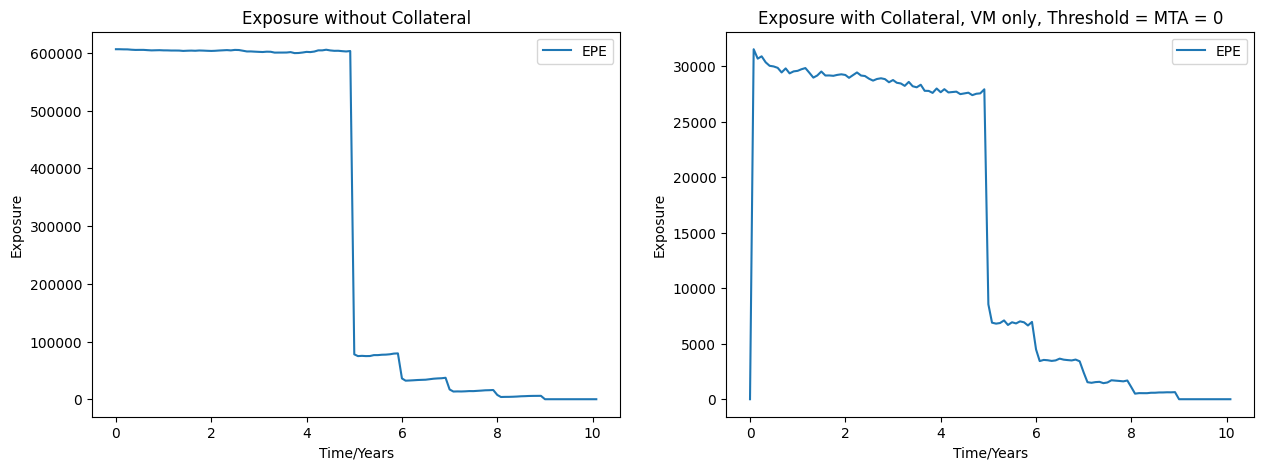

In [3]:
# get the uncollateralized exposure from the trade exposure report
report_none = ore_vm.getReport("exposure_trade_BermudanSwaptionCash")
# get the collateralized exposure from the netting set report
report_vm = ore_vm.getReport("exposure_nettingset_CPTY_A")

time = report_vm.dataAsReal(2)
epe_none = report_none.dataAsReal(3)
epe_vm = report_vm.dataAsReal(3)

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_none, label='EPE')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Exposure')
ax0.set_title('Exposure without Collateral')
ax0.legend()

ax1.plot(time, epe_vm, label='EPE')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='Exposure')
ax1.set_title('Exposure with Collateral, VM only, Threshold = MTA = 0')
ax1.legend()

plt.show()

Note:
- The exposure on the right is just due to the Margin Period of Risk
- Ballpark factor 20 reduced compared to the uncollateralized exposure.

# Example 2: Add Initial Margin

We now switch to American Monte Carlo on the Computation Graph (AMC/CG) in order to compute dynamic AAD sensitivities and Dynamic SIMM and run again. Check the essential differences in our setups, ore_im.xml vs ore_vm.xml:

| Parameter | ore_im.xml | ore_vm.xml |
| --- | --- | --- |
| simulation/amcCg | CubeGeneration | Disabled |
| simulation/xvaCgDynamicIM | true | false |
| xva/csaFile | netting_im.xml | netting_vm.xml |
| xva/dim | true | false |
| xva/mva | true | false |

and note that the netting_im.xml file has the ApplyInitialMargin flag set to true.

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~44sec (i.e. doubling the run time of Example 1)

In [4]:
params_im = Parameters()
params_im.fromFile("Input/Dim2/ore_im.xml")
ore_im = OREApp(params_im)
ore_im.run()
utilities.checkErrorsAndRunTime(ore_im)
utilities.writeList(ore_im.getReportNames())

Run time: 43.70 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dim_cube
- dim_distribution
- dim_evolution
- dim_regression_0
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva


### Plot Expected IM and Exposure after VM+IM

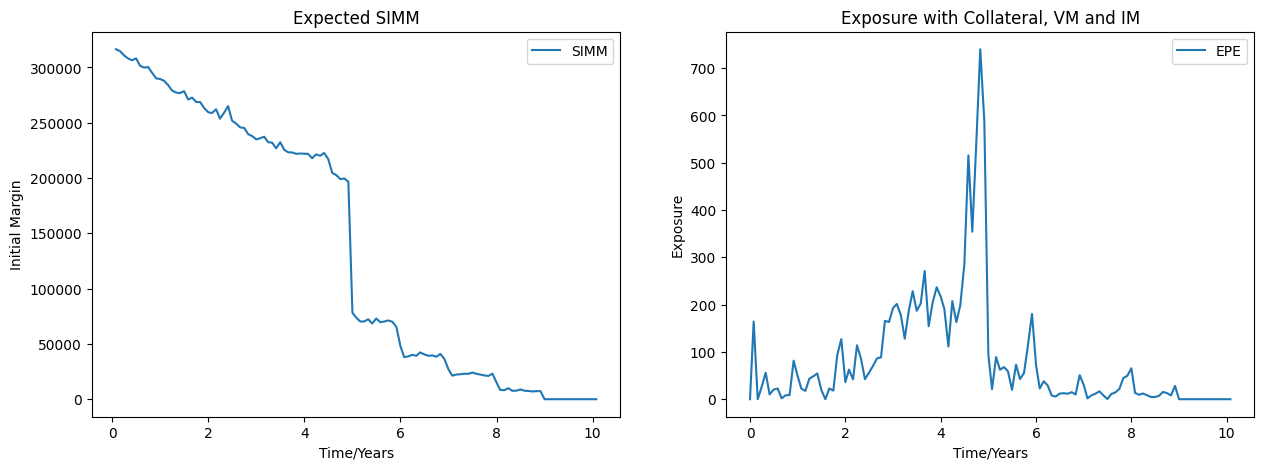

In [5]:
# get the Dynamic Initial Margin evolution report
report_dim = ore_im.getReport("dim_evolution")
# get the exposure from the netting set report
report_exp = ore_im.getReport("exposure_nettingset_CPTY_A")

time_dim = report_dim.dataAsReal(8)
dim = report_dim.dataAsReal(4)

time_epe = report_exp.dataAsReal(2)
epe = report_exp.dataAsReal(3)

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time_dim, dim, label='SIMM')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Initial Margin')
ax0.set_title('Expected SIMM')
ax0.legend()

ax1.plot(time_epe, epe, label='EPE')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='Exposure')
ax1.set_title('Exposure with Collateral, VM and IM')
ax1.legend()

plt.show()

### Note

- Expected SIMM far exceeds the expected exposure after VM here, it feeds directly into the MVA calculaton below
- Residual exposure after VM and IM is small and suffers from poor statistics - small number of MC samples contribute to EPE, even though we are using a stressed market with elevated Swaption volatility (see Example 3 below)

### MVA

Expected Discounted SIMM feeds directly into the calculation of MVA, written to the xva report (output file Output/Dim2/AmcCg/xva.csv), 
\begin{align}
\mathit{MVA} &= \sum_{i=1}^n (f_b - s_I)\times \delta_i \times S_{ours}(t_i)\times S_{theirs}(t_i) \times \mathbb{E}^N\left[
\frac{\mathit{DIM}(t_i)}{N(t_i)}\right].  
\end{align}
for an arbitrary spread $f_b-s_I = 0.01$, "our" survival probability $S_{ours}(t)=1$ and counterparty survival probability $S_{theirs}(t)=\exp(-h\,t)$ with flat hazard rate $h=0.01$ in this Example 2.

### Choice of regression method and the Python integration layer

For the evaluation of conditional expectations of sensitivities under AMC we have used simple polynomial regression of order 4 here. We have shown here (https://ssrn.com/abstract=5517378) that **local regression** can be more appropriate in case of option products. 

Local regression methods can be applied in ORE with the help of ORE's Python integration layer (not to be confused with the ORE Python module) that offers regression methods such as MARS (in the py-earth2 Python package) and various others (contained in the scikit-learn Python package). See the ORE user guide for instructions on how to build ORE with this integration and how to parametrise ORE to use it.

# Example 3: Repeat Example 2 with 100k Samples

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~330sec (i.e. factor 15 compared to Example 1)

In [6]:
params_im_100k = Parameters()
params_im_100k.fromFile("Input/Dim2/ore_im_100k.xml")
ore_im_100k = OREApp(params_im_100k)
ore_im_100k.run()
utilities.checkErrorsAndRunTime(ore_im_100k)
utilities.writeList(ore_im_100k.getReportNames())

Run time: 337.14 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dim_cube
- dim_distribution
- dim_evolution
- dim_regression_0
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva


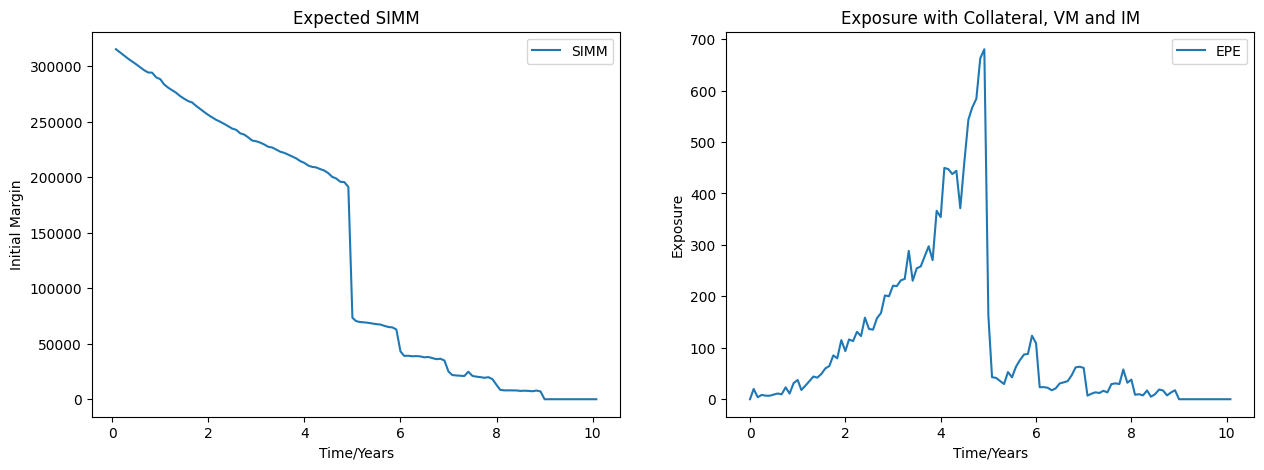

In [7]:
# get the Dynamic Initial Margin evolution report
report_dim_100k = ore_im_100k.getReport("dim_evolution")
# get the exposure from the netting set report
report_exp_100k = ore_im_100k.getReport("exposure_nettingset_CPTY_A")

time_dim = report_dim_100k.dataAsReal(8)
dim = report_dim_100k.dataAsReal(4)

time_epe = report_exp_100k.dataAsReal(2)
epe = report_exp_100k.dataAsReal(3)

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time_dim, dim, label='SIMM')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Initial Margin')
ax0.set_title('Expected SIMM')
ax0.legend()

ax1.plot(time_epe, epe, label='EPE')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='Exposure')
ax1.set_title('Exposure with Collateral, VM and IM')
ax1.legend()

plt.show()

As expected, less noisy than above but confirming the IM and Exposure evolutions obtained with 10k samples.